In [1]:
# MIT License

# Copyright (c) [2019] [Jayden Booth]

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# Import Libraries
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Dense, GaussianNoise,Lambda,Dropout, Concatenate
from keras.models import Model
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,SGD
from keras import backend as K
from keras.constraints import max_norm
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import special

Using TensorFlow backend.


In [2]:
# Set random seeds
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(3)

In [3]:
# Set the defining parameters
# n = n_channel complex numbers (so 2n real numbers)
# k = log2(M), where M is the number of messages to encode
# EbNo is the energy per bit to noise power density

# Encoder Parameters
M = 16
k = np.log2(M)
n_channel = 1
R = k/n_channel

#Power splitting ratio
rho = 0
eps=1
eta=1
print('number of symbols:',M)



number of symbols: 16


In [4]:
def set_up_train_nn(P,EsNodB):
    label = np.random.randint(M,size=N)

    # creating one hot encoded vectors
    data = []
    for i in label:
        temp = np.zeros(M)
        temp[i] = 1
        data.append(temp)

    # checking data shape
    data = np.array(data)
    print (data.shape)


    # Defined Autoencoder
    batch_size = 4096
    
    # Transmitter Layers
    input_signal = Input(shape=(M,))
    encoded = Dense(M, activation='relu')(input_signal)
    encoded2 = Dense(8, activation='relu')(encoded)
    encoded2 = Dense(4, activation='relu')(encoded)
    encoded2 = Dense(2*n_channel, activation='linear')(encoded)

    # Normalize Power
    encoded3 = BatchNormalization(momentum=0,epsilon=1e-6,center=False,scale=False,axis=1)(encoded2)
    encoded3 = Lambda(lambda x: x*np.sqrt(P/2))(encoded3)

    #adding channel noise
    encoded4 = Lambda(lambda x: x+K.random_normal_variable((32768*2,2), 0,np.sqrt(0.05))[0:tf.shape(x)[0],:])(encoded3)


    # Slicing into CD and PD data, and applying noise

    cd_data = Lambda(lambda x: np.sqrt(rho)*np.sqrt(eps)*x)(encoded4)
    
    
    pd_data = Lambda(lambda x: K.expand_dims((1-rho)*eta*eps*K.sum(K.square(x),axis=1),axis=1))(encoded4)
    pd_data = Lambda(lambda x: x+K.random_normal_variable((32768*2,1), 0,np.sqrt(1))[0:tf.shape(x)[0]])(pd_data)

    #combining the split data to feed the decoder
    data_split=[]
    data_split.append(cd_data)
    data_split.append(pd_data)

    data_split =  Concatenate(axis=1)(data_split)


    # Reciever Layer
    decoded = Dense(2, activation='linear')(data_split)
    decoded = Dense(4, activation='relu')(decoded)
    decoded = Dense(8, activation='relu')(decoded)
    decoded1 = Dense(M, activation='softmax')(decoded)
    autoencoder = Model(input_signal, decoded1)

    adam = Adam(lr=0.075)
    sgd = SGD(lr=0.5)
    autoencoder.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy','mse'])

    # printing summary of layers and it's trainable parameters 
    print (autoencoder.summary())

    # traning auto encoder
    autoencoder.fit(data, data,
                    epochs=200,
                    batch_size=batch_size)

    # making encoder from full autoencoder
    encoder = Model(input_signal, encoded3)

    # for plotting learned consteallation diagram

    scatter_plot = []
    for i in range(0,M):
        temp = np.zeros(M)
        temp[i] = 1
        scatter_plot.append(encoder.predict(np.expand_dims(temp,axis=0)))
    scatter_plot = np.array(scatter_plot)
    print (scatter_plot.shape)

    # ploting constellation diagram
    import matplotlib.pyplot as plt
    scatter_plot = scatter_plot.reshape(M,2,1)

    plt.scatter(scatter_plot[:,0],scatter_plot[:,1])
    #plt.axis((-2,2,-2,2))
    plt.grid()
    #plt.title('Splitting Receiver: rho = '+str(rho)+' eps = '+str(eps))
    plt.xlabel('I Axis')
    plt.ylabel('Q Axis')
    plt.show()
    p_av = np.sum(np.square(scatter_plot),axis=1)
    print(sum(p_av)/16)

    return autoencoder

(20000, 16)
Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 16)           272         input_1[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 2)            34          dense_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 2)            4           dense_4[0][0]                    
_________________________

20000/20000 [==============================] - 0s 2us/step - loss: 1.1823 - acc: 0.4699 - mean_squared_error: 0.0395
Epoch 34/200
20000/20000 [==============================] - 0s 2us/step - loss: 1.1803 - acc: 0.4766 - mean_squared_error: 0.0395
Epoch 35/200
20000/20000 [==============================] - 0s 2us/step - loss: 1.1975 - acc: 0.4421 - mean_squared_error: 0.0400
Epoch 36/200
20000/20000 [==============================] - 0s 2us/step - loss: 1.1772 - acc: 0.4646 - mean_squared_error: 0.0394
Epoch 37/200
20000/20000 [==============================] - 0s 2us/step - loss: 1.1597 - acc: 0.4685 - mean_squared_error: 0.0391
Epoch 38/200
20000/20000 [==============================] - 0s 2us/step - loss: 1.1499 - acc: 0.4571 - mean_squared_error: 0.0389
Epoch 39/200
20000/20000 [==============================] - 0s 2us/step - loss: 1.1405 - acc: 0.4883 - mean_squared_error: 0.0386
Epoch 40/200
20000/20000 [==============================] - 0s 2us/step - loss: 1.1479 - acc: 0.4691 - 

20000/20000 [==============================] - 0s 2us/step - loss: 1.0323 - acc: 0.5251 - mean_squared_error: 0.0358
Epoch 97/200
20000/20000 [==============================] - 0s 3us/step - loss: 1.0400 - acc: 0.5166 - mean_squared_error: 0.0360
Epoch 98/200
20000/20000 [==============================] - 0s 2us/step - loss: 1.0370 - acc: 0.5230 - mean_squared_error: 0.0357
Epoch 99/200
20000/20000 [==============================] - 0s 2us/step - loss: 1.0399 - acc: 0.5068 - mean_squared_error: 0.0360
Epoch 100/200
20000/20000 [==============================] - 0s 2us/step - loss: 1.0526 - acc: 0.5158 - mean_squared_error: 0.0362
Epoch 101/200
20000/20000 [==============================] - 0s 2us/step - loss: 1.0391 - acc: 0.5231 - mean_squared_error: 0.0357
Epoch 102/200
20000/20000 [==============================] - 0s 2us/step - loss: 1.0352 - acc: 0.5147 - mean_squared_error: 0.0360
Epoch 103/200
20000/20000 [==============================] - 0s 2us/step - loss: 1.0390 - acc: 0.513

20000/20000 [==============================] - 0s 3us/step - loss: 1.0402 - acc: 0.5000 - mean_squared_error: 0.0360
Epoch 159/200
20000/20000 [==============================] - 0s 2us/step - loss: 1.0090 - acc: 0.5252 - mean_squared_error: 0.0351
Epoch 160/200
20000/20000 [==============================] - 0s 3us/step - loss: 1.0276 - acc: 0.5084 - mean_squared_error: 0.0357
Epoch 161/200
20000/20000 [==============================] - 0s 2us/step - loss: 1.0116 - acc: 0.5186 - mean_squared_error: 0.0351
Epoch 162/200
20000/20000 [==============================] - 0s 3us/step - loss: 0.9923 - acc: 0.5363 - mean_squared_error: 0.0344
Epoch 163/200
20000/20000 [==============================] - 0s 3us/step - loss: 0.9941 - acc: 0.5323 - mean_squared_error: 0.0345
Epoch 164/200
20000/20000 [==============================] - 0s 3us/step - loss: 1.0056 - acc: 0.5238 - mean_squared_error: 0.0349
Epoch 165/200
20000/20000 [==============================] - 0s 3us/step - loss: 0.9903 - acc: 0.

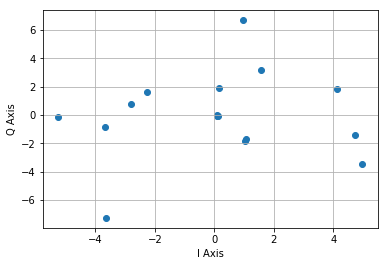

[17.186073]
Es/No: 12 SER: 0.4506 Theor_SER_PAM: 0.5075803579279314
(75000, 16)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 16)           272         input_2[0][0]                    
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 2)            34          dense_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 2)            4           dense_12[0][0]                   
_____________________________

75000/75000 [==============================] - 0s 3us/step - loss: 0.7214 - acc: 0.7031 - mean_squared_error: 0.0262
Epoch 38/200
75000/75000 [==============================] - 0s 3us/step - loss: 0.7429 - acc: 0.6874 - mean_squared_error: 0.0270
Epoch 39/200
75000/75000 [==============================] - 0s 3us/step - loss: 0.7051 - acc: 0.7159 - mean_squared_error: 0.0255
Epoch 40/200
75000/75000 [==============================] - 0s 3us/step - loss: 0.7126 - acc: 0.7096 - mean_squared_error: 0.0260
Epoch 41/200
75000/75000 [==============================] - 0s 3us/step - loss: 0.7437 - acc: 0.6950 - mean_squared_error: 0.0270
Epoch 42/200
75000/75000 [==============================] - 0s 3us/step - loss: 0.7315 - acc: 0.6839 - mean_squared_error: 0.0269
Epoch 43/200
75000/75000 [==============================] - 0s 4us/step - loss: 0.7105 - acc: 0.7065 - mean_squared_error: 0.0260
Epoch 44/200
75000/75000 [==============================] - 0s 3us/step - loss: 0.6904 - acc: 0.7267 - 

75000/75000 [==============================] - 0s 4us/step - loss: 0.5742 - acc: 0.7626 - mean_squared_error: 0.0214
Epoch 101/200
75000/75000 [==============================] - 0s 4us/step - loss: 0.5757 - acc: 0.7563 - mean_squared_error: 0.0214
Epoch 102/200
75000/75000 [==============================] - 0s 4us/step - loss: 0.6063 - acc: 0.7333 - mean_squared_error: 0.0227
Epoch 103/200
75000/75000 [==============================] - 0s 4us/step - loss: 0.5820 - acc: 0.7519 - mean_squared_error: 0.0217
Epoch 104/200
75000/75000 [==============================] - 0s 4us/step - loss: 0.5785 - acc: 0.7455 - mean_squared_error: 0.0217
Epoch 105/200
75000/75000 [==============================] - 0s 4us/step - loss: 0.6281 - acc: 0.7185 - mean_squared_error: 0.0236
Epoch 106/200
75000/75000 [==============================] - 0s 4us/step - loss: 0.5822 - acc: 0.7516 - mean_squared_error: 0.0217
Epoch 107/200
75000/75000 [==============================] - 0s 4us/step - loss: 0.5642 - acc: 0.

75000/75000 [==============================] - 0s 5us/step - loss: 0.5598 - acc: 0.7516 - mean_squared_error: 0.0212
Epoch 163/200
75000/75000 [==============================] - 0s 5us/step - loss: 0.6847 - acc: 0.6836 - mean_squared_error: 0.0260
Epoch 164/200
75000/75000 [==============================] - 0s 5us/step - loss: 0.6118 - acc: 0.7263 - mean_squared_error: 0.0229
Epoch 165/200
75000/75000 [==============================] - 0s 5us/step - loss: 0.5691 - acc: 0.7519 - mean_squared_error: 0.0212
Epoch 166/200
75000/75000 [==============================] - 0s 5us/step - loss: 0.5543 - acc: 0.7569 - mean_squared_error: 0.0209
Epoch 167/200
75000/75000 [==============================] - 0s 5us/step - loss: 0.5759 - acc: 0.7401 - mean_squared_error: 0.0218
Epoch 168/200
75000/75000 [==============================] - 0s 5us/step - loss: 0.5638 - acc: 0.7445 - mean_squared_error: 0.0214
Epoch 169/200
75000/75000 [==============================] - 0s 5us/step - loss: 0.5639 - acc: 0.

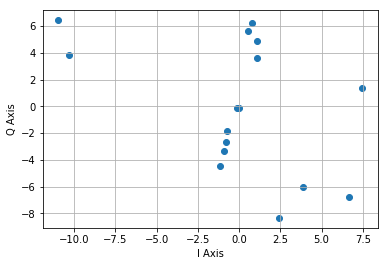

[44.458607]
Es/No: 16 SER: 0.2096 Theor_SER_PAM: 0.3123019621637889
(65000, 16)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 16)           272         input_3[0][0]                    
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 2)            34          dense_17[0][0]                   
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 2)            4           dense_20[0][0]                   
_____________________________

65000/65000 [==============================] - 0s 6us/step - loss: 0.3584 - acc: 0.8688 - mean_squared_error: 0.0129
Epoch 38/200
65000/65000 [==============================] - 0s 6us/step - loss: 0.3624 - acc: 0.8637 - mean_squared_error: 0.0131
Epoch 39/200
65000/65000 [==============================] - 0s 6us/step - loss: 0.5376 - acc: 0.7697 - mean_squared_error: 0.0203
Epoch 40/200
65000/65000 [==============================] - 0s 5us/step - loss: 0.4543 - acc: 0.8204 - mean_squared_error: 0.0165
Epoch 41/200
65000/65000 [==============================] - 0s 5us/step - loss: 0.3822 - acc: 0.8444 - mean_squared_error: 0.0143
Epoch 42/200
65000/65000 [==============================] - 0s 5us/step - loss: 0.3515 - acc: 0.8647 - mean_squared_error: 0.0128
Epoch 43/200
65000/65000 [==============================] - 0s 6us/step - loss: 0.4230 - acc: 0.8191 - mean_squared_error: 0.0161
Epoch 44/200
65000/65000 [==============================] - 0s 6us/step - loss: 0.2866 - acc: 0.9037 - 

65000/65000 [==============================] - 0s 6us/step - loss: 0.3491 - acc: 0.8567 - mean_squared_error: 0.0131
Epoch 101/200
65000/65000 [==============================] - 0s 6us/step - loss: 0.3407 - acc: 0.8669 - mean_squared_error: 0.0125
Epoch 102/200
65000/65000 [==============================] - 0s 6us/step - loss: 0.2369 - acc: 0.9150 - mean_squared_error: 0.0083
Epoch 103/200
65000/65000 [==============================] - 0s 6us/step - loss: 0.2017 - acc: 0.9301 - mean_squared_error: 0.0069
Epoch 104/200
65000/65000 [==============================] - 0s 6us/step - loss: 0.2481 - acc: 0.9027 - mean_squared_error: 0.0090
Epoch 105/200
65000/65000 [==============================] - 0s 6us/step - loss: 0.3040 - acc: 0.8780 - mean_squared_error: 0.0112
Epoch 106/200
65000/65000 [==============================] - 0s 6us/step - loss: 0.3335 - acc: 0.8650 - mean_squared_error: 0.0124
Epoch 107/200
65000/65000 [==============================] - 0s 6us/step - loss: 0.3316 - acc: 0.

65000/65000 [==============================] - 0s 6us/step - loss: 0.4282 - acc: 0.8368 - mean_squared_error: 0.0152
Epoch 163/200
65000/65000 [==============================] - 1s 9us/step - loss: 0.3355 - acc: 0.8666 - mean_squared_error: 0.0124
Epoch 164/200
65000/65000 [==============================] - 0s 6us/step - loss: 0.2691 - acc: 0.9015 - mean_squared_error: 0.0095
Epoch 165/200
65000/65000 [==============================] - 0s 7us/step - loss: 0.2406 - acc: 0.9136 - mean_squared_error: 0.0084
Epoch 166/200
65000/65000 [==============================] - 0s 7us/step - loss: 0.2491 - acc: 0.9088 - mean_squared_error: 0.0088
Epoch 167/200
65000/65000 [==============================] - 0s 6us/step - loss: 0.2164 - acc: 0.9222 - mean_squared_error: 0.0075
Epoch 168/200
65000/65000 [==============================] - 0s 6us/step - loss: 0.2648 - acc: 0.9029 - mean_squared_error: 0.0094
Epoch 169/200
65000/65000 [==============================] - 0s 7us/step - loss: 0.2549 - acc: 0.

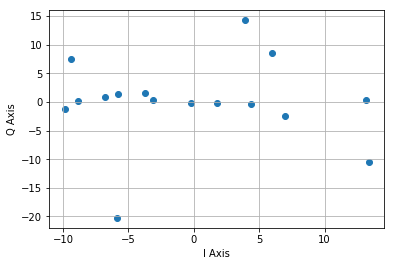

[108.82607]
Es/No: 20 SER: 0.1194 Theor_SER_PAM: 0.11723145012290671
(75000, 16)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 16)           272         input_4[0][0]                    
__________________________________________________________________________________________________
dense_28 (Dense)                (None, 2)            34          dense_25[0][0]                   
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 2)            4           dense_28[0][0]                   
____________________________

75000/75000 [==============================] - 0s 6us/step - loss: 2.7733 - acc: 0.0624 - mean_squared_error: 0.0586
Epoch 38/200
75000/75000 [==============================] - 1s 7us/step - loss: 2.7733 - acc: 0.0625 - mean_squared_error: 0.0586
Epoch 39/200
75000/75000 [==============================] - 0s 6us/step - loss: 2.7732 - acc: 0.0629 - mean_squared_error: 0.0586
Epoch 40/200
75000/75000 [==============================] - 0s 6us/step - loss: 2.7733 - acc: 0.0634 - mean_squared_error: 0.0586
Epoch 41/200
75000/75000 [==============================] - 0s 5us/step - loss: 2.7736 - acc: 0.0633 - mean_squared_error: 0.0586
Epoch 42/200
75000/75000 [==============================] - 0s 6us/step - loss: 2.7738 - acc: 0.0624 - mean_squared_error: 0.0586
Epoch 43/200
75000/75000 [==============================] - 0s 6us/step - loss: 2.7738 - acc: 0.0624 - mean_squared_error: 0.0586
Epoch 44/200
75000/75000 [==============================] - 0s 5us/step - loss: 2.7730 - acc: 0.0632 - 

75000/75000 [==============================] - 0s 6us/step - loss: 2.7737 - acc: 0.0624 - mean_squared_error: 0.0586
Epoch 100/200
75000/75000 [==============================] - 0s 6us/step - loss: 2.7738 - acc: 0.0633 - mean_squared_error: 0.0586
Epoch 101/200
75000/75000 [==============================] - 0s 6us/step - loss: 2.7735 - acc: 0.0620 - mean_squared_error: 0.0586
Epoch 102/200
75000/75000 [==============================] - 0s 6us/step - loss: 2.7740 - acc: 0.0614 - mean_squared_error: 0.0586
Epoch 103/200
75000/75000 [==============================] - 0s 7us/step - loss: 2.7741 - acc: 0.0629 - mean_squared_error: 0.0586
Epoch 104/200
75000/75000 [==============================] - 1s 8us/step - loss: 2.7735 - acc: 0.0623 - mean_squared_error: 0.0586
Epoch 105/200
75000/75000 [==============================] - 1s 8us/step - loss: 2.7737 - acc: 0.0629 - mean_squared_error: 0.0586
Epoch 106/200
75000/75000 [==============================] - 1s 7us/step - loss: 2.7740 - acc: 0.

75000/75000 [==============================] - 0s 4us/step - loss: 2.7737 - acc: 0.0621 - mean_squared_error: 0.0586
Epoch 162/200
75000/75000 [==============================] - 0s 4us/step - loss: 2.7739 - acc: 0.0609 - mean_squared_error: 0.0586
Epoch 163/200
75000/75000 [==============================] - 0s 5us/step - loss: 2.7734 - acc: 0.0631 - mean_squared_error: 0.0586
Epoch 164/200
75000/75000 [==============================] - 0s 4us/step - loss: 2.7735 - acc: 0.0630 - mean_squared_error: 0.0586
Epoch 165/200
75000/75000 [==============================] - 0s 4us/step - loss: 2.7733 - acc: 0.0625 - mean_squared_error: 0.0586
Epoch 166/200
75000/75000 [==============================] - 0s 4us/step - loss: 2.7735 - acc: 0.0629 - mean_squared_error: 0.0586
Epoch 167/200
75000/75000 [==============================] - 0s 4us/step - loss: 2.7735 - acc: 0.0621 - mean_squared_error: 0.0586
Epoch 168/200
75000/75000 [==============================] - 0s 4us/step - loss: 2.7735 - acc: 0.

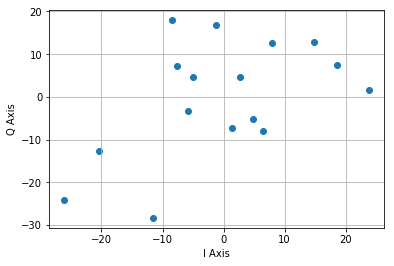

[341.53394]
Es/No: 25 SER: 0.93852 Theor_SER_PAM: 0.00597813169126268
(21000, 16)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
dense_33 (Dense)                (None, 16)           272         input_5[0][0]                    
__________________________________________________________________________________________________
dense_36 (Dense)                (None, 2)            34          dense_33[0][0]                   
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 2)            4           dense_36[0][0]                   
___________________________

21000/21000 [==============================] - 0s 13us/step - loss: 15.1442 - acc: 0.0604 - mean_squared_error: 0.1174
Epoch 38/200
21000/21000 [==============================] - 0s 11us/step - loss: 15.1442 - acc: 0.0604 - mean_squared_error: 0.1174
Epoch 39/200
21000/21000 [==============================] - 0s 13us/step - loss: 15.1442 - acc: 0.0604 - mean_squared_error: 0.1174
Epoch 40/200
21000/21000 [==============================] - 0s 12us/step - loss: 15.1442 - acc: 0.0604 - mean_squared_error: 0.1174
Epoch 41/200
21000/21000 [==============================] - 0s 13us/step - loss: 15.1442 - acc: 0.0604 - mean_squared_error: 0.1174
Epoch 42/200
21000/21000 [==============================] - 0s 10us/step - loss: 15.1442 - acc: 0.0604 - mean_squared_error: 0.1174
Epoch 43/200
21000/21000 [==============================] - 0s 10us/step - loss: 15.1442 - acc: 0.0604 - mean_squared_error: 0.1174
Epoch 44/200
21000/21000 [==============================] - 0s 10us/step - loss: 15.1442 

21000/21000 [==============================] - 0s 11us/step - loss: 15.1442 - acc: 0.0604 - mean_squared_error: 0.1174
Epoch 99/200
21000/21000 [==============================] - 0s 12us/step - loss: 15.1442 - acc: 0.0604 - mean_squared_error: 0.1174
Epoch 100/200
21000/21000 [==============================] - 0s 13us/step - loss: 15.1442 - acc: 0.0604 - mean_squared_error: 0.1174
Epoch 101/200
21000/21000 [==============================] - 0s 12us/step - loss: 15.1442 - acc: 0.0604 - mean_squared_error: 0.1174
Epoch 102/200
21000/21000 [==============================] - 0s 13us/step - loss: 15.1442 - acc: 0.0604 - mean_squared_error: 0.1174
Epoch 103/200
21000/21000 [==============================] - 0s 13us/step - loss: 15.1442 - acc: 0.0604 - mean_squared_error: 0.1174
Epoch 104/200
21000/21000 [==============================] - 0s 13us/step - loss: 15.1442 - acc: 0.0604 - mean_squared_error: 0.1174
Epoch 105/200
21000/21000 [==============================] - 0s 14us/step - loss: 15

21000/21000 [==============================] - 0s 13us/step - loss: 15.1442 - acc: 0.0604 - mean_squared_error: 0.1174
Epoch 160/200
21000/21000 [==============================] - 0s 11us/step - loss: 15.1442 - acc: 0.0604 - mean_squared_error: 0.1174
Epoch 161/200
21000/21000 [==============================] - 0s 12us/step - loss: 15.1442 - acc: 0.0604 - mean_squared_error: 0.1174
Epoch 162/200
21000/21000 [==============================] - 0s 12us/step - loss: 15.1442 - acc: 0.0604 - mean_squared_error: 0.1174
Epoch 163/200
21000/21000 [==============================] - 0s 11us/step - loss: 15.1442 - acc: 0.0604 - mean_squared_error: 0.1174
Epoch 164/200
21000/21000 [==============================] - 0s 11us/step - loss: 15.1442 - acc: 0.0604 - mean_squared_error: 0.1174
Epoch 165/200
21000/21000 [==============================] - 0s 12us/step - loss: 15.1442 - acc: 0.0604 - mean_squared_error: 0.1174
Epoch 166/200
21000/21000 [==============================] - 0s 11us/step - loss: 1

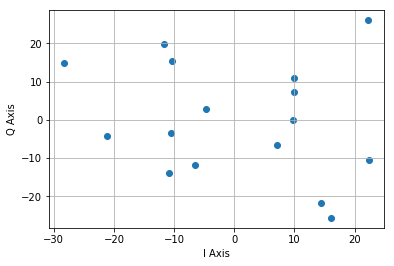

[432.9032]
Es/No: 26 SER: 0.9393333333333334 Theor_SER_PAM: 0.0020709317187892974


In [5]:
EsNodB_range = [12,16,20,25,26]
N_array=[20000,75000,65000,75000,21000]
ser = [None]*len(EsNodB_range)
theor_ser_qam = [None]*len(EsNodB_range)
theor_ser = [None]*len(EsNodB_range)

noise_std = np.sqrt(1.1)
for n in range(0,len(EsNodB_range)):
    
    EsNo=10.0**(EsNodB_range[n]/10.0)
    P = EsNo*(noise_std**2)
    
    no_errors = 0
    
    N=N_array[n]
   
    
    autoencoder = set_up_train_nn(P,EsNodB_range[n])
    
    # generating data for checking SER
    test_label = np.random.randint(M,size=N)
    test_data = []

    for i in test_label:
        temp = np.zeros(M)
        temp[i] = 1
        test_data.append(temp)

    test_data = np.array(test_data)
    
    pred_final_signal = autoencoder.predict(test_data)
    
    pred_output = np.argmax(pred_final_signal,axis=1)
    no_errors = (pred_output != test_label)
    no_errors =  no_errors.astype(int).sum()
    ser[n] = no_errors / N 
    
    P_sqrtM = 0.75*special.erfc(np.sqrt(EsNo/10))
    theor_ser_qam[n] = 1-(1-P_sqrtM)**2
    theor_ser[n] = (15/16)*special.erfc(np.sqrt(EsNo/85))
    
    print ('Es/No:',EsNodB_range[n],'SER:',ser[n],'Theor_SER_PAM:',theor_ser[n])
    

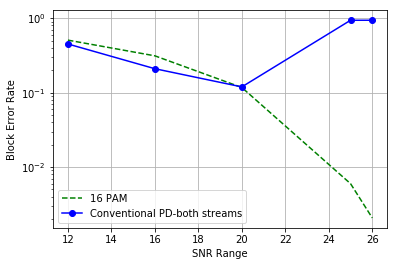

In [6]:
plt.plot(EsNodB_range, theor_ser, 'g--',label='16 PAM')
plt.plot(EsNodB_range, ser, 'bo-',label='Conventional PD-both streams')
plt.yscale('log')
plt.xlabel('SNR Range')
plt.ylabel('Block Error Rate')
plt.grid()
plt.legend(loc='best',ncol = 1)
plt.show()

In [7]:
ser

[0.4506, 0.2096, 0.1194, 0.93852, 0.9393333333333334]